In [89]:
%run 0_local_library_setup.ipynb

In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager

import time

In [3]:
def spotify_write_df_to_data_out_csv(pd_df, filename):
    pd_df.to_csv(f'data_out/{filename}.csv', index = False)

In [4]:
def spotify_get_all_results(access_token \
                            , endpoint \
                            , content_type \
                            , query = {} \
                            , max_parse_level = 0 \
                            , base_obj = None):
    api_call_headers = {
        'Authorization': 'Bearer ' + access_token,
        'Content-Type': content_type
    }

    next_api_url = endpoint

    first_call = True
    retVal_list = list()

    while next_api_url is not None:        
        api_request = requests.get(next_api_url, headers = api_call_headers, params = query if first_call else {})
        api_request.raise_for_status()

        api_request_json = api_request.json()
        
        if base_obj is not None:
            #Too simple for JMESPath...
            api_request_json = api_request_json[base_obj]

        if first_call:
            num_pages = int(np.ceil(api_request_json['total'] / api_request_json['limit']))

            desc_style = {'description_width': 'initial'}
            api_request_loading_bar = widgets.IntProgress(value = 0 \
                                                            , min = 0 \
                                                            , max = num_pages \
                                                            , description = 'Loading:' \
                                                            , bar_style = 'success' \
                                                            , orientation='horizontal' \
                                                            , style = desc_style\
                                                           )

            first_call = False

            display(api_request_loading_bar)

        next_api_url = api_request_json['next']

        retVal_list.append(pd.json_normalize(api_request_json['items'], max_level = max_parse_level))

        api_request_loading_bar.value += 1

        if api_request_loading_bar.value < num_pages:
            api_request_loading_bar.description = f'Loading Page: {api_request_loading_bar.value + 1} of {num_pages}'

    api_request_loading_bar.layout.display = 'none'
    
    return pd.concat(retVal_list).reset_index(drop = True)

In [5]:
driver = webdriver.Chrome(service = Service(ChromeDriverManager().install()))

spotify_accounts_endpoint = 'https://accounts.spotify.com/'
spotify_api_endpoint = 'https://api.spotify.com/v1/'

with open('config/config.yml', 'r') as file:
    config_contents = yaml.safe_load(file)
    
config_contents_creds = config_contents['creds']

client_id = config_contents_creds['client_id']
client_secret = config_contents_creds['client_secret']

redirect_uri = config_contents['redirect_uri']

oath_token_url = f'{spotify_accounts_endpoint}authorize?client_id={client_id}&response_type=code&redirect_uri={redirect_uri}&scope=user-read-private user-read-email playlist-read-private user-follow-read user-top-read user-read-recently-played user-library-read'

driver.get(oath_token_url)

username_input = driver.find_element('id', 'login-username')
username_input.send_keys(config_contents_creds['username'])

password_input = driver.find_element('id', 'login-password')
password_input.send_keys(config_contents_creds['password'])

login_button = driver.find_element('id', 'login-button')
login_button.click()

if (driver.current_url.startswith(f'{spotify_accounts_endpoint}en/authorize?')):
    agree_button = driver.find_element('xpath', '//button[@data-testid="auth-accept"]')
    agree_button.click()
    
time.sleep(2)
    
oauth_initial_token = driver.current_url.replace(f'{redirect_uri}/?code=', '')

driver.close()
driver.quit()

[WDM] - Downloading: 100%|███████████████████████████████████████████████████████████████████| 8.72M/8.72M [00:00<00:00, 13.6MB/s]


In [6]:
base64_encoding = 'ascii'
content_type_dictionary = {'Content-Type': 'application/x-www-form-urlencoded'}

get_bearer_token_headers = {
  'Authorization': 'Basic ' + \
                    base64.b64encode(f'{client_id}:{client_secret}'.encode(base64_encoding)).decode(base64_encoding)
} | content_type_dictionary

get_bearer_token_payload = {
    'grant_type': 'authorization_code',
    'code': oauth_initial_token,
    'redirect_uri': redirect_uri
}

get_bearer_token_response = requests.post(f'{spotify_accounts_endpoint}api/token' \
                                          , headers = get_bearer_token_headers \
                                          , data = get_bearer_token_payload)
get_bearer_token_response.raise_for_status()

get_bearer_token_response_json = get_bearer_token_response.json()
access_token = get_bearer_token_response_json['access_token']

In [7]:
track_str = 'track'
track_id_str = f'{track_str}_id'

added_at_str = 'added_at'

my_tracks = spotify_get_all_results(access_token \
                                    , f'{spotify_api_endpoint}me/tracks' \
                                    , 'application/x-www-form-urlencoded' \
                                    , max_parse_level = 1)

my_tracks.columns = my_tracks.columns.str.replace(f'{track_str}.', '', regex = False)
my_tracks.rename(columns = {'id': track_id_str}, inplace = True)

my_tracks[added_at_str] = pd.to_datetime(my_tracks[added_at_str])

display(my_tracks.head())
print(my_tracks.shape)

IntProgress(value=0, bar_style='success', description='Loading:', max=68, style=ProgressStyle(description_widt…

,added_at,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,track_id,is_local,name,popularity,preview_url,track_number,type,uri
0,2023-01-26 01:51:19+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,100750,True,{'isrc': 'QM6N22019015'},{'spotify': 'https://open.spotify.com/track/5l...,https://api.spotify.com/v1/tracks/5lCtzEEl2Fxy...,5lCtzEEl2FxySHX4zR9yEf,False,kissing girls,54,https://p.scdn.co/mp3-preview/8c06490304618d53...,2,track,spotify:track:5lCtzEEl2FxySHX4zR9yEf
1,2022-12-11 21:16:46+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,197146,False,{'isrc': 'USRH10175221'},{'spotify': 'https://open.spotify.com/track/1h...,https://api.spotify.com/v1/tracks/1hQFF33xi8ru...,1hQFF33xi8ruavZNyovtUN,False,"December, 1963 (Oh What a Night!)",72,https://p.scdn.co/mp3-preview/4467108ca55c4342...,6,track,spotify:track:1hQFF33xi8ruavZNyovtUN
2,2022-12-11 20:44:51+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AE, AG, AM, AU, AZ, BB, BD, BH, BN, BS, BT, B...",1,181133,False,{'isrc': 'USY4W0610011'},{'spotify': 'https://open.spotify.com/track/0q...,https://api.spotify.com/v1/tracks/0q21FNwES2bb...,0q21FNwES2bbtcduB6kjEU,False,Dancing in the Moonlight,71,https://p.scdn.co/mp3-preview/b9e3c265713dbbd3...,10,track,spotify:track:0q21FNwES2bbtcduB6kjEU
3,2022-12-11 20:41:46+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,160133,False,{'isrc': 'USC4R0817643'},{'spotify': 'https://open.spotify.com/track/2L...,https://api.spotify.com/v1/tracks/2LawezPeJhN4...,2LawezPeJhN4AWuSB0GtAU,False,Have You Ever Seen The Rain,82,https://p.scdn.co/mp3-preview/137ba4561d72545c...,4,track,spotify:track:2LawezPeJhN4AWuSB0GtAU
4,2022-12-11 00:39:53+00:00,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AG, AL, AM, AO, AR, AT, AU, AZ, BA, B...",1,190160,False,{'isrc': 'USRC11100481'},{'spotify': 'https://open.spotify.com/track/1Y...,https://api.spotify.com/v1/tracks/1YYhDizHx7Pn...,1YYhDizHx7PnDhAhko6cDS,False,"Take Me Home, Country Roads",71,https://p.scdn.co/mp3-preview/bf19d9dc9afc9d79...,7,track,spotify:track:1YYhDizHx7PnDhAhko6cDS


(1342, 18)


In [8]:
spotify_write_df_to_data_out_csv(my_tracks, 'track_details_output')

In [9]:
artists_str = 'artists'

track_artists_df = convert_json_col_to_dataframe_with_key(my_tracks, track_id_str, artists_str)

display(track_artists_df.head())
print(track_artists_df.shape)

,track_id,external_urls,href,id,name,type,uri
0,5lCtzEEl2FxySHX4zR9yEf,{'spotify': 'https://open.spotify.com/artist/6...,https://api.spotify.com/v1/artists/6FmiNnTXQJT...,6FmiNnTXQJTmOMAx4kB38R,Grady,artist,spotify:artist:6FmiNnTXQJTmOMAx4kB38R
1,1hQFF33xi8ruavZNyovtUN,{'spotify': 'https://open.spotify.com/artist/6...,https://api.spotify.com/v1/artists/6mcrZQmgzFG...,6mcrZQmgzFGRWf7C0SObou,Frankie Valli & The Four Seasons,artist,spotify:artist:6mcrZQmgzFGRWf7C0SObou
2,0q21FNwES2bbtcduB6kjEU,{'spotify': 'https://open.spotify.com/artist/5...,https://api.spotify.com/v1/artists/5FHwr1FymaS...,5FHwr1FymaS5kutIEK6e2y,King Harvest,artist,spotify:artist:5FHwr1FymaS5kutIEK6e2y
3,2LawezPeJhN4AWuSB0GtAU,{'spotify': 'https://open.spotify.com/artist/3...,https://api.spotify.com/v1/artists/3IYUhFvPQIt...,3IYUhFvPQItj6xySrBmZkd,Creedence Clearwater Revival,artist,spotify:artist:3IYUhFvPQItj6xySrBmZkd
4,1YYhDizHx7PnDhAhko6cDS,{'spotify': 'https://open.spotify.com/artist/7...,https://api.spotify.com/v1/artists/7EK1bQADBoq...,7EK1bQADBoqbYXnT4Cqv9w,John Denver,artist,spotify:artist:7EK1bQADBoqbYXnT4Cqv9w


(1533, 7)


In [10]:
spotify_write_df_to_data_out_csv(track_artists_df, 'track_artists_output')

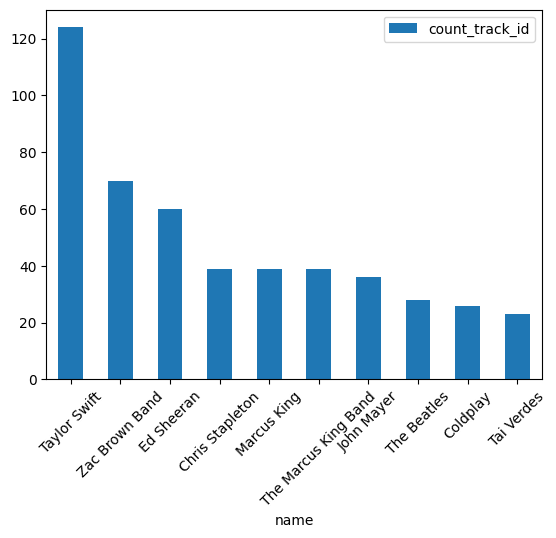

<Figure size 640x480 with 0 Axes>

In [11]:
id_str = 'id'
name_str = 'name'
count_track_id_str = f'count_{track_id_str}'

num_tracks_per_artist = track_artists_df.groupby([id_str, name_str])[track_id_str].count() \
                                        .to_frame().sort_values(track_id_str, ascending = False) \
                                        .reset_index().rename(columns = {track_id_str: count_track_id_str})

num_tracks_per_artist.head(10).plot(kind = 'bar', x = name_str, y = count_track_id_str, rot = 45)

plt.show()
plt.clf()

In [12]:
display(num_tracks_per_artist[num_tracks_per_artist[count_track_id_str] >= 2][[name_str, count_track_id_str]])

,name,count_track_id
0,Taylor Swift,124
1,Zac Brown Band,70
2,Ed Sheeran,60
3,Chris Stapleton,39
4,Marcus King,39
5,The Marcus King Band,39
6,John Mayer,36
7,The Beatles,28
8,Coldplay,26
9,Tai Verdes,23


In [13]:
display(num_tracks_per_artist[num_tracks_per_artist[count_track_id_str] == 1][[name_str, count_track_id_str]])

,name,count_track_id
172,Four Tops,1
173,The Isley Brothers,1
174,Adam Melchor,1
175,Macy Gray,1
176,Carrie Underwood,1
177,Lil Wayne,1
178,O-Town,1
179,Gary Portnoy,1
180,Noah Cyrus,1
181,Ashland Craft,1


In [14]:
my_long_term_top_tracks = spotify_get_all_results(access_token \
                                                 , f'{spotify_api_endpoint}me/top/tracks' \
                                                 , 'application/json' \
                                                 , query = {'time_range': 'long_term'})

display(my_long_term_top_tracks)

IntProgress(value=0, bar_style='success', description='Loading:', max=3, style=ProgressStyle(description_width…

,album,artists,available_markets,disc_number,duration_ms,explicit,external_ids,external_urls,href,id,is_local,name,popularity,preview_url,track_number,type,uri
0,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,240600,False,{'isrc': 'USSM11800493'},{'spotify': 'https://open.spotify.com/track/1O...,https://api.spotify.com/v1/tracks/1Omt5bfz1tZU...,1Omt5bfz1tZUCqd26HxbS0,False,Beyond,71,https://p.scdn.co/mp3-preview/d292ddde93535d73...,4,track,spotify:track:1Omt5bfz1tZUCqd26HxbS0
1,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,613026,True,{'isrc': 'USUG12103690'},{'spotify': 'https://open.spotify.com/track/5e...,https://api.spotify.com/v1/tracks/5enxwA8aAbwZ...,5enxwA8aAbwZbf5qCHORXi,False,All Too Well (10 Minute Version) (Taylor's Ver...,80,https://p.scdn.co/mp3-preview/bfe8fd2f71ccfbee...,30,track,spotify:track:5enxwA8aAbwZbf5qCHORXi
2,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,204852,True,{'isrc': 'USUG12205717'},{'spotify': 'https://open.spotify.com/track/5o...,https://api.spotify.com/v1/tracks/5oqDgw5VGBln...,5oqDgw5VGBln5dSIOPWyBq,False,Karma,77,https://p.scdn.co/mp3-preview/84aae068ba78f3c6...,11,track,spotify:track:5oqDgw5VGBln5dSIOPWyBq
3,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,260361,False,{'isrc': 'USUG12207556'},{'spotify': 'https://open.spotify.com/track/0a...,https://api.spotify.com/v1/tracks/0aV5uARAknQg...,0aV5uARAknQgYhBaK944FP,False,"Would've, Could've, Should've",80,https://p.scdn.co/mp3-preview/3344e743c832a223...,19,track,spotify:track:0aV5uARAknQgYhBaK944FP
4,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,294520,True,{'isrc': 'USUG12002848'},{'spotify': 'https://open.spotify.com/track/3I...,https://api.spotify.com/v1/tracks/3IhtE4fkytdr...,3IhtE4fkytdrtEfV34UzkD,False,betty,62,https://p.scdn.co/mp3-preview/9dd54ccc09528313...,14,track,spotify:track:3IhtE4fkytdrtEfV34UzkD
5,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,218333,False,{'isrc': 'USC4R1802465'},{'spotify': 'https://open.spotify.com/track/2W...,https://api.spotify.com/v1/tracks/2WgbFkQQswVV...,2WgbFkQQswVVEWnyKnFo2q,False,All My Friends,49,https://p.scdn.co/mp3-preview/5331bb793e14d554...,2,track,spotify:track:2WgbFkQQswVVEWnyKnFo2q
6,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,298666,False,{'isrc': 'USUM70760674'},{'spotify': 'https://open.spotify.com/track/2Z...,https://api.spotify.com/v1/tracks/2ZkbT2NZYVdA...,2ZkbT2NZYVdAk14puSae5a,False,Turning Home,30,https://p.scdn.co/mp3-preview/b0c4608d3d2f5e24...,10,track,spotify:track:2ZkbT2NZYVdAk14puSae5a
7,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,285106,True,{'isrc': 'USUG12103686'},{'spotify': 'https://open.spotify.com/track/4C...,https://api.spotify.com/v1/tracks/4CkgMiMqZ5Jz...,4CkgMiMqZ5JzW9iYXSTMTL,False,I Bet You Think About Me (feat. Chris Stapleto...,71,https://p.scdn.co/mp3-preview/45260aa995e2d521...,26,track,spotify:track:4CkgMiMqZ5JzW9iYXSTMTL
8,"{'album_type': 'ALBUM', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,"[AD, AE, AR, AT, AU, BE, BG, BH, BO, BR, CA, C...",1,280864,False,{'isrc': 'QMRSZ1901394'},{'spotify': 'https://open.spotify.com/track/0s...,https://api.spotify.com/v1/tr

In [15]:
#TODO top songs by artist

In [16]:
my_followed_artists = spotify_get_all_results(access_token \
                                              , f'{spotify_api_endpoint}me/following' \
                                              , 'application/json' \
                                              , query = {'type': 'artist'} \
                                              , base_obj = 'artists')

display(my_followed_artists)

IntProgress(value=0, bar_style='success', description='Loading:', max=2, style=ProgressStyle(description_width…

,external_urls,followers,genres,href,id,images,name,popularity,type,uri
0,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 39461918}",[pop],https://api.spotify.com/v1/artists/04gDigrS5kc...,04gDigrS5kc9YWfZHwBETP,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Maroon 5,87,artist,spotify:artist:04gDigrS5kc9YWfZHwBETP
1,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 66862212}",[pop],https://api.spotify.com/v1/artists/06HL4z0CvFA...,06HL4z0CvFAxyc27GXpf02,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Taylor Swift,99,artist,spotify:artist:06HL4z0CvFAxyc27GXpf02
2,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 19078661}","[alternative rock, funk metal, funk rock, perm...",https://api.spotify.com/v1/artists/0L8ExT028jH...,0L8ExT028jH3ddEcZwqJJ5,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Red Hot Chili Peppers,84,artist,spotify:artist:0L8ExT028jH3ddEcZwqJJ5
3,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 46004612}","[dance pop, pop]",https://api.spotify.com/v1/artists/0du5cEVh5yT...,0du5cEVh5yTK9QJze8zA0C,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Bruno Mars,90,artist,spotify:artist:0du5cEVh5yTK9QJze8zA0C
4,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 5756341}","[neo mellow, singer-songwriter]",https://api.spotify.com/v1/artists/0hEurMDQu99...,0hEurMDQu99nJRq8pTxO14,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",John Mayer,80,artist,spotify:artist:0hEurMDQu99nJRq8pTxO14
5,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 1597385}","[alternative rock, neo mellow, pop rock, rock]",https://api.spotify.com/v1/artists/0vEsuISMWAK...,0vEsuISMWAKNctLlUAhSZC,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Counting Crows,70,artist,spotify:artist:0vEsuISMWAKNctLlUAhSZC
6,{'spotify': 'https://open.spotify.com/artist/0...,"{'href': None, 'total': 3831999}","[neo mellow, piano rock, pop, pop rock]",https://api.spotify.com/v1/artists/0zOcE3mg9nS...,0zOcE3mg9nS6l3yxt1Y0bK,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",The Fray,70,artist,spotify:artist:0zOcE3mg9nS6l3yxt1Y0bK
7,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 23718827}",[pop],https://api.spotify.com/v1/artists/1McMsnEElTh...,1McMsnEElThX1knmY4oliG,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Olivia Rodrigo,85,artist,spotify:artist:1McMsnEElThX1knmY4oliG
8,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 45006166}","[classic rock, glam rock, rock]",https://api.spotify.com/v1/artists/1dfeR4HaWDb...,1dfeR4HaWDbWqFHLkxsg1d,"[{'height': 806, 'url': 'https://i.scdn.co/ima...",Queen,86,artist,spotify:artist:1dfeR4HaWDbWqFHLkxsg1d
9,{'spotify': 'https://open.spotify.com/artist/1...,"{'href': None, 'total': 1139353}","[neo mellow, pop punk, pop rock]",https://api.spotify.com/v1/artists/1g1yxsNVPhM...,1g1yxsNVPhMUl9GrMjEb2o,"[{'height': 640, 'url': 'https://i.scdn.co/ima...",Plain White T's,65,artist,spotify:artist:1g1yxsNVPhMUl9GrMjEb2o


In [17]:
my_track_artists = num_tracks_per_artist[[id_str, name_str, count_track_id_str]]

display(my_track_artists)

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
4,0FeWKiZSwBRdGzqeCdlH1a,Marcus King,39
...,...,...,...
550,2ysnwxxNtSgbb9t1m2Ur4j,George Ezra,1
551,2xiIXseIJcq3nG7C8fHeBj,Three Days Grace,1
552,2xaAOVImG2O6lURwqperlD,Catfish and the Bottlemen,1
553,2xTlb6eueddQmWsxImpDbP,Sarah Buxton,1


In [18]:
my_left = my_track_artists
my_right = my_followed_artists

my_followed_and_liked_artists_df = pd.merge(my_left \
                                            , my_right \
                                            , on = id_str \
                                            , how = 'inner' \
                                            , suffixes = ('', '_y'))[my_left.columns]

display(my_followed_and_liked_artists_df)
print(my_followed_and_liked_artists_df.shape)

,id,name,count_track_id
0,06HL4z0CvFAxyc27GXpf02,Taylor Swift,124
1,6yJCxee7QumYr820xdIsjo,Zac Brown Band,70
2,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,60
3,4YLtscXsxbVgi031ovDDdh,Chris Stapleton,39
4,0hEurMDQu99nJRq8pTxO14,John Mayer,36
5,3WrFJ7ztbogyGnTHbHJFl2,The Beatles,28
6,4gzpq5DPGxSnKTe4SA8HAU,Coldplay,26
7,3qnGvpP8Yth1AqSBMqON5x,Leon Bridges,19
8,3eqjTLE0HfPfh78zjh6TqT,Bruce Springsteen,18
9,0L8ExT028jH3ddEcZwqJJ5,Red Hot Chili Peppers,18


(34, 3)


In [19]:
my_track_artists_ids = set(my_left[id_str])
my_followed_artists_ids = set(my_right[id_str])
my_followed_and_liked_artists_ids = set(my_followed_and_liked_artists_df[id_str])

my_unfollowed_track_artists_ids = my_track_artists_ids - my_followed_and_liked_artists_ids
my_followed_and_nonliked_artists_ids = my_followed_artists_ids - my_followed_and_liked_artists_ids

#TODO handle when my_followed_and_nonliked_artists_ids is non-empty

my_unfollowed_track_artists_df = my_left[my_left[id_str].isin(my_unfollowed_track_artists_ids)]

my_top_unfollowed_artists_indices = my_unfollowed_track_artists_df[count_track_id_str] > 2

my_top_unfollowed_artists_df = my_unfollowed_track_artists_df[my_top_unfollowed_artists_indices] \
                                    .reset_index(drop = True)

display(my_top_unfollowed_artists_df)
print(my_top_unfollowed_artists_df.shape)

,id,name,count_track_id
0,0FeWKiZSwBRdGzqeCdlH1a,Marcus King,39
1,0tgaHqkU1p7QhBUIzKXVU9,The Marcus King Band,39
2,2kCO8LXN1usaOPL3iEE28I,Tai Verdes,23
3,6WY7D3jk8zTrHtmkqqo5GI,Maren Morris,16
4,3UUJfRbrA2nTbcg4i0MOwu,Original Broadway Cast of Hamilton,9
5,4DZGvSv2oMkBUnPz67E6z6,David Nail,9
6,4wQ3PyMz3WwJGI5uEqHUVR,Allman Brothers Band,9
7,5kuJibJcwOC53s3OkoGMRA,The Revivalists,8
8,3M4ThdJR28z9eSMcQHAZ5G,The Fratellis,8
9,67ea9eGLXYMsO2eYQRui3w,The Who,7


(70, 3)


In [151]:
added_at_ym_str = added_at_str + '_ym'
added_at_ymd_str = added_at_ym_str + 'd'

track_artists_df_with_added_at = pd.merge(track_artists_df, my_tracks[[track_id_str, added_at_str]] \
                                         , on = track_id_str)

track_artists_df_with_added_at[added_at_ym_str] = track_artists_df_with_added_at[added_at_str].dt.strftime('%Y-%m')
track_artists_df_with_added_at[added_at_ymd_str] = track_artists_df_with_added_at[added_at_str].dt.date

added_at_date_range_pd_series = track_artists_df_with_added_at[added_at_ymd_str]

added_at_date_range_df = pd.date_range(start = added_at_date_range_pd_series.min() \
                                       , end = added_at_date_range_pd_series.max()) \
                             .strftime('%Y-%m').drop_duplicates() \
                             .to_frame().reset_index(drop = True).rename(columns = {0: added_at_ym_str})

unique_artists_df = track_artists_df_with_added_at[[id_str, name_str]].drop_duplicates().reset_index(drop = True)

unique_artists_all_dates_list = list()
    
for i, df_row in unique_artists_df.iterrows():
    tmp_unique_artist_base = unique_artists_df.iloc[[i]].reset_index(drop = True)
    
    tmp_unique_artist = pd.concat([added_at_date_range_df, tmp_unique_artist_base], axis = 1)
    
    for curr_col in tmp_unique_artist_base.columns:
        tmp_unique_artist[curr_col].fillna(df_row[curr_col], inplace = True)
    
    unique_artists_all_dates_list.append(tmp_unique_artist)

unique_artists_all_dates_df = pd.concat(unique_artists_all_dates_list).reset_index(drop = True)

In [160]:
artist_month_indexes = [id_str, name_str, added_at_ym_str]

num_tracks_per_artist_month = track_artists_df_with_added_at.groupby(artist_month_indexes)[track_id_str].count() \
                                        .to_frame().sort_values(added_at_ym_str) \
                                        .reset_index().rename(columns = {track_id_str: count_track_id_str})

num_tracks_per_artist_month = pd.merge(num_tracks_per_artist_month \
                                       , unique_artists_all_dates_df \
                                       , on = artist_month_indexes \
                                       , how = 'outer' \
                                       , sort = True).fillna(0)

display(num_tracks_per_artist_month.head(100))

,id,name,added_at_ym,count_track_id
0,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2021-12,1.0
1,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-01,0.0
2,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-02,0.0
3,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-03,0.0
4,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-04,0.0
5,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-05,0.0
6,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-06,0.0
7,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-07,0.0
8,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-08,0.0
9,00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,2022-09,0.0


In [161]:
runningsum_str = 'runningsum'

num_tracks_per_artist_month[runningsum_str] = num_tracks_per_artist_month.groupby([id_str])[count_track_id_str].cumsum()

display(num_tracks_per_artist_month[num_tracks_per_artist_month[name_str] == 'Taylor Swift'])

,id,name,added_at_ym,count_track_id,runningsum
98,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2021-12,21.0,21.0
99,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-01,55.0,76.0
100,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-02,33.0,109.0
101,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-03,0.0,109.0
102,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-04,0.0,109.0
103,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-05,0.0,109.0
104,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-06,0.0,109.0
105,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-07,0.0,109.0
106,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-08,0.0,109.0
107,06HL4z0CvFAxyc27GXpf02,Taylor Swift,2022-09,0.0,109.0


In [163]:
num_tracks_per_artist_month_pivot = num_tracks_per_artist_month.pivot_table(values = runningsum_str \
                                                                           , index = [id_str, name_str] \
                                                                           , columns = added_at_ym_str \
                                                                           , fill_value = 0)

display(num_tracks_per_artist_month_pivot)

,added_at_ym,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01
id,name,,,,,,,,,,,,,,
00tVTdpEhQQw1bqdu8RCx2,Blue Öyster Cult,1,1,1,1,1,1,1,1,1,1,1,1,1,1
01QTIT5P1pFP3QnnFSdsJf,Lupe Fiasco,1,1,1,1,1,1,1,1,1,1,1,1,1,1
01lz5VBfkMFDteSA9pKJuP,The Click Five,1,1,1,1,1,1,1,1,1,1,1,1,1,1
02seUFsFQP7TH4hLrTj77o,Nathaniel Rateliff & The Night Sweats,0,2,2,2,2,2,2,2,2,2,2,4,4,4
04RtvnUz0XrUbUZzOA8ZoW,Sugarcult,1,1,1,1,1,1,1,1,1,1,1,1,1,1
04gDigrS5kc9YWfZHwBETP,Maroon 5,17,17,17,17,17,17,17,17,17,17,17,17,17,17
0543y7yrvny4KymoaneT4W,Peter Frampton,1,1,1,1,1,1,1,1,1,1,1,1,1,1
06HL4z0CvFAxyc27GXpf02,Taylor Swift,21,76,109,109,109,109,109,109,109,109,124,124,124,124
06nevPmNVfWUXyZkccahL8,Gregory Porter,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [164]:
num_tracks_per_artist_month_pivot.reset_index(inplace = True)

spotify_write_df_to_data_out_csv(num_tracks_per_artist_month_pivot, 'num_tracks_per_artist_month_pivot_output')

display(num_tracks_per_artist_month_pivot[num_tracks_per_artist_month_pivot[name_str] == 'Taylor Swift'])

added_at_ym,id,name,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01
7,06HL4z0CvFAxyc27GXpf02,Taylor Swift,21,76,109,109,109,109,109,109,109,109,124,124,124,124
